## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

## Import Data

In [2]:
df = pd.read_excel('premiums_young.xlsx')

print(f'The number of Rows is {df.shape[0]}')
print(f'The number of Cols is {df.shape[1]}')

The number of Rows is 20096
The number of Cols is 13


In [3]:
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


In [4]:
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount'],
      dtype='object')

## Data Cleaning

### Handle NA values

In [5]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
df.shape

(20090, 13)

In [8]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

### Handle Duplicates

In [9]:
df.duplicated().sum()

np.int64(0)

In [10]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

### Handle outliers

In [11]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267
std,2.294052,0.940713,23.420493,2749.906347
min,18.000000,-3.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


#### Handle Outliers : number_of_dependants

In [12]:
df[df.number_of_dependants < 0]['number_of_dependants'].unique()

array([-3, -1])

In [13]:
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    20090.000000
mean         0.722598
std          0.937200
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: number_of_dependants, dtype: float64

#### Handle Outliers : numerical columns

In [14]:
numerical_cols = df.select_dtypes(['float64', 'int64']).columns
numerical_cols

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

In [15]:
def boxPlots(data, cols):
    for col in cols:
        sns.boxplot(data, x=col)
        plt.show()

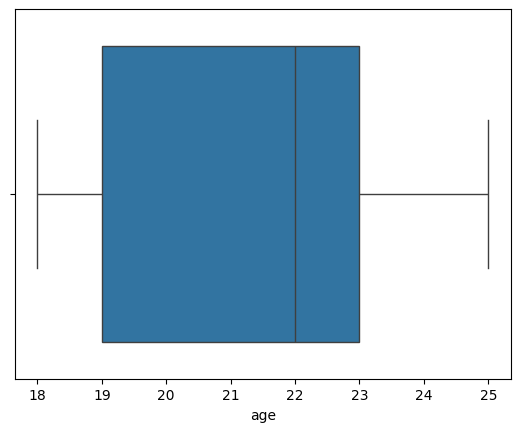

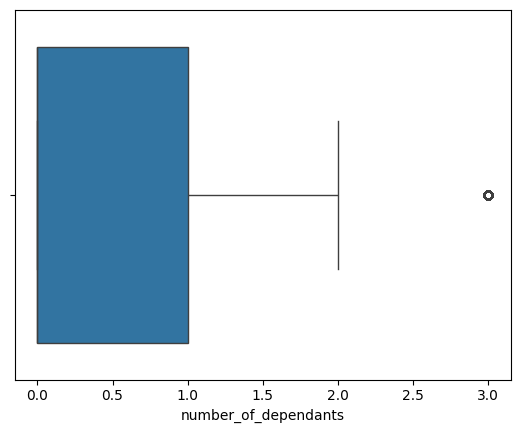

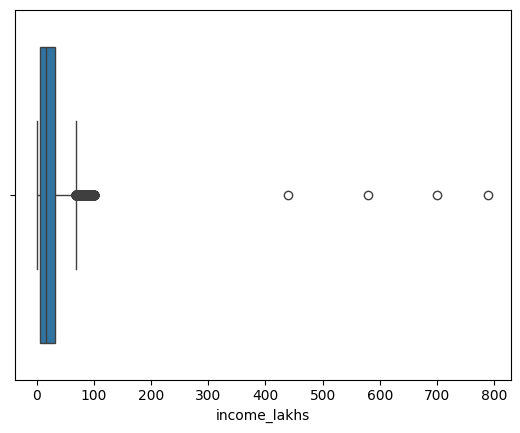

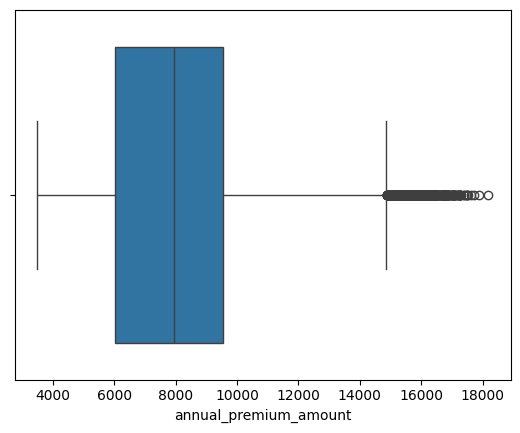

In [16]:
boxPlots(df, numerical_cols)

##### Handle Outliers : numerical columns (age)

In [17]:
df[df.age > 100].shape

(0, 13)

In [18]:
df1 = df[df.age < 100].copy()

In [19]:
df1.shape

(20090, 13)

In [20]:
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267
std,2.294052,0.937200,23.420493,2749.906347
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


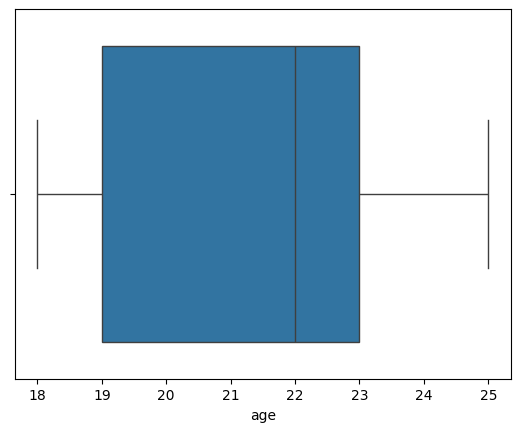

In [21]:
boxPlots(df1, ['age'])

##### Handle Outliers : numerical columns (income_lakhs)

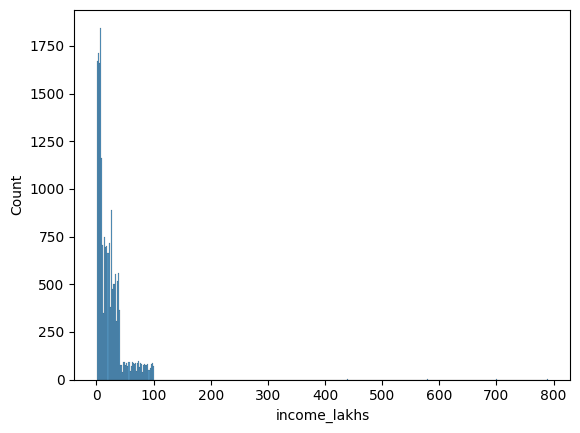

In [22]:
sns.histplot(df1, x='income_lakhs')
plt.show()

In [23]:
def get_iqr_bounds(col):
    q1, q3 = col.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

In [24]:
lower_bound, upper_bound = get_iqr_bounds(df1['income_lakhs'])
lower_bound, upper_bound

(-31.5, 68.5)

In [25]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

np.float64(100.0)

In [26]:
df2 = df1[df1.income_lakhs <= quantile_threshold].copy()
df2.shape

(20086, 13)

In [27]:
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20086.000000,20086.000000,20086.000000,20086.000000
mean,21.494474,0.722742,22.390371,8141.799263
std,2.294248,0.937238,21.732062,2749.912486
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.000000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,100.000000,18186.000000


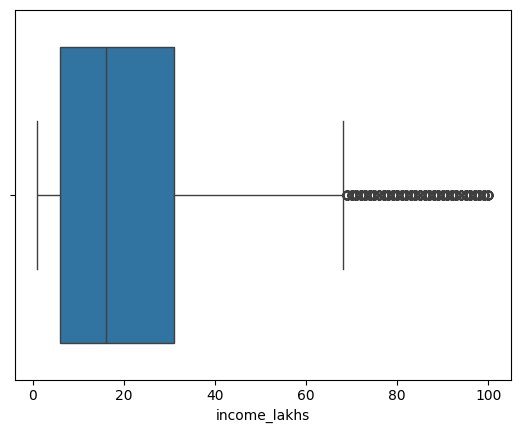

In [28]:
boxPlots(df2, ['income_lakhs'])

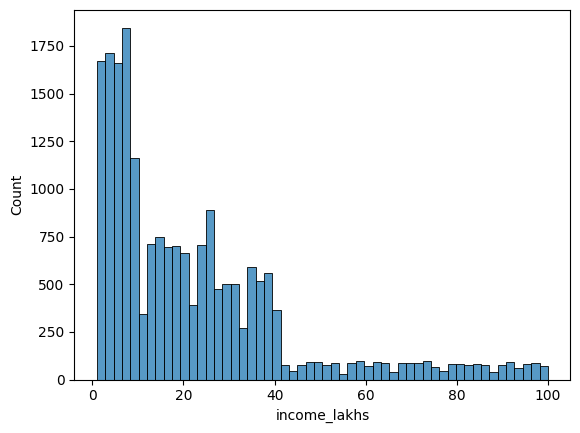

In [29]:
sns.histplot(df2, x='income_lakhs')
plt.show()

## Data Analysis

### Data Analysis : numerical columns

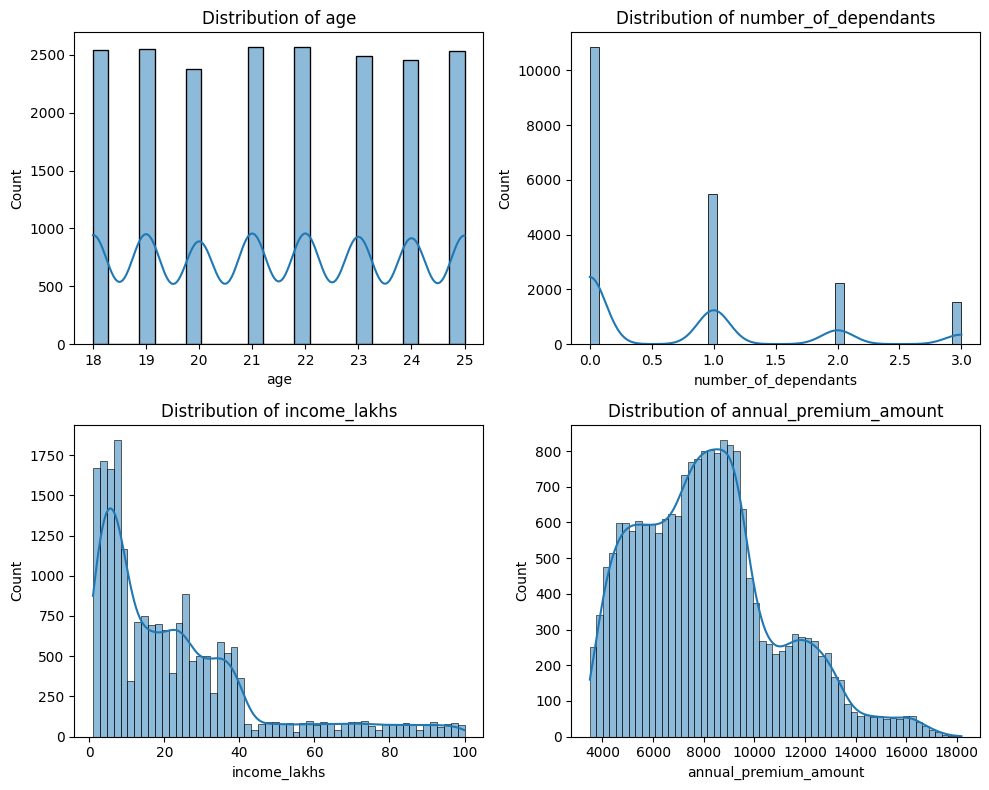

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2x2 grid

for ax, col in zip(axes.flatten(), numerical_cols[:4]):  # [:4] just in case you have more than 4
    sns.histplot(df2, x=col, kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

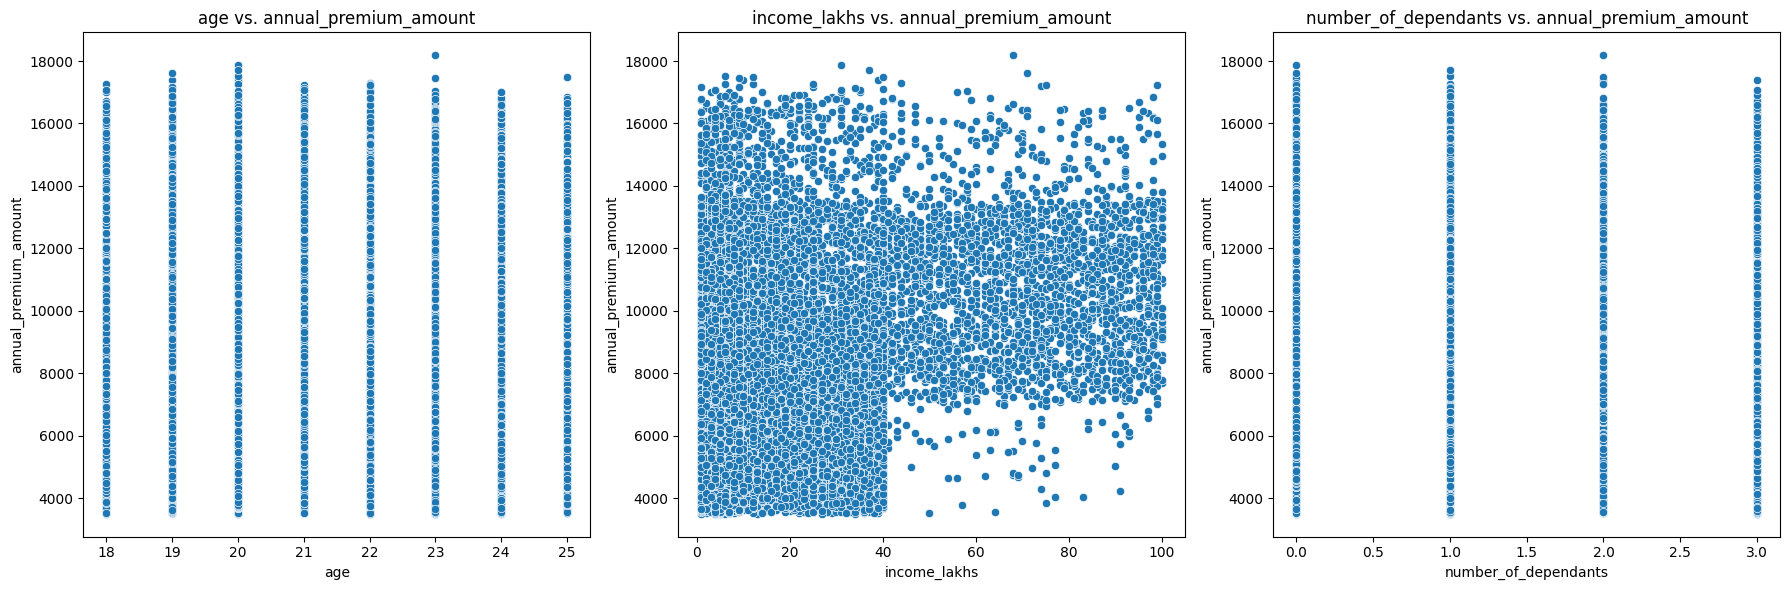

In [31]:
numeric_features = ['age', 'income_lakhs', 'number_of_dependants']
target = 'annual_premium_amount'

fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 6))  # 2x2 grid

for ax, col in zip(axes, numeric_features):
    sns.scatterplot(x=df2[col], y=df2[target], ax=ax)
    ax.set_title(f'{col} vs. {target}')
    ax.set_xlabel(col)
    ax.set_ylabel(target)

plt.tight_layout()
plt.show()

### Data Analysis : Categorical columns

In [32]:
df2.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [33]:
categorical_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']

categorical_cols

['gender',
 'region',
 'marital_status',
 'bmi_category',
 'smoking_status',
 'employment_status',
 'income_level',
 'medical_history',
 'insurance_plan']

In [34]:
for col in categorical_cols:
    print(f' {col} : {df2[col].unique()}')

 gender : ['Male' 'Female']
 region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
 marital_status : ['Unmarried' 'Married']
 bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
 smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
 employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
 income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
 medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
 insurance_plan : ['Silver' 'Bronze' 'Gold']


In [35]:
df2['smoking_status'].replace({
        'Smoking=0': 'No Smoking',
        'Does Not Smoke': 'No Smoking',
        'Not Smoking': 'No Smoking',
}, inplace=True)
df2.smoking_status.unique()

C:\Users\Ahmad Fahim\AppData\Local\Temp\ipykernel_17696\1051042033.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['smoking_status'].replace({


array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

#### Univariate Analysis : Categorical columns

In [36]:
def barPlot(data, cols):
    n_cols = 3  # number of plots per row
    n_rows = (len(cols) + n_cols - 1) // n_cols  # ceiling division for rows

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten()  # to loop easily

    for i, col in enumerate(cols):
        pct_count = data[col].value_counts(normalize=True)
        sns.barplot(x=pct_count.index, y=pct_count.values, ax=axes[i])
        axes[i].set_title(f'{col} Distribution')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Proportion')

    # Hide unused subplots if cols is not a multiple of 3
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

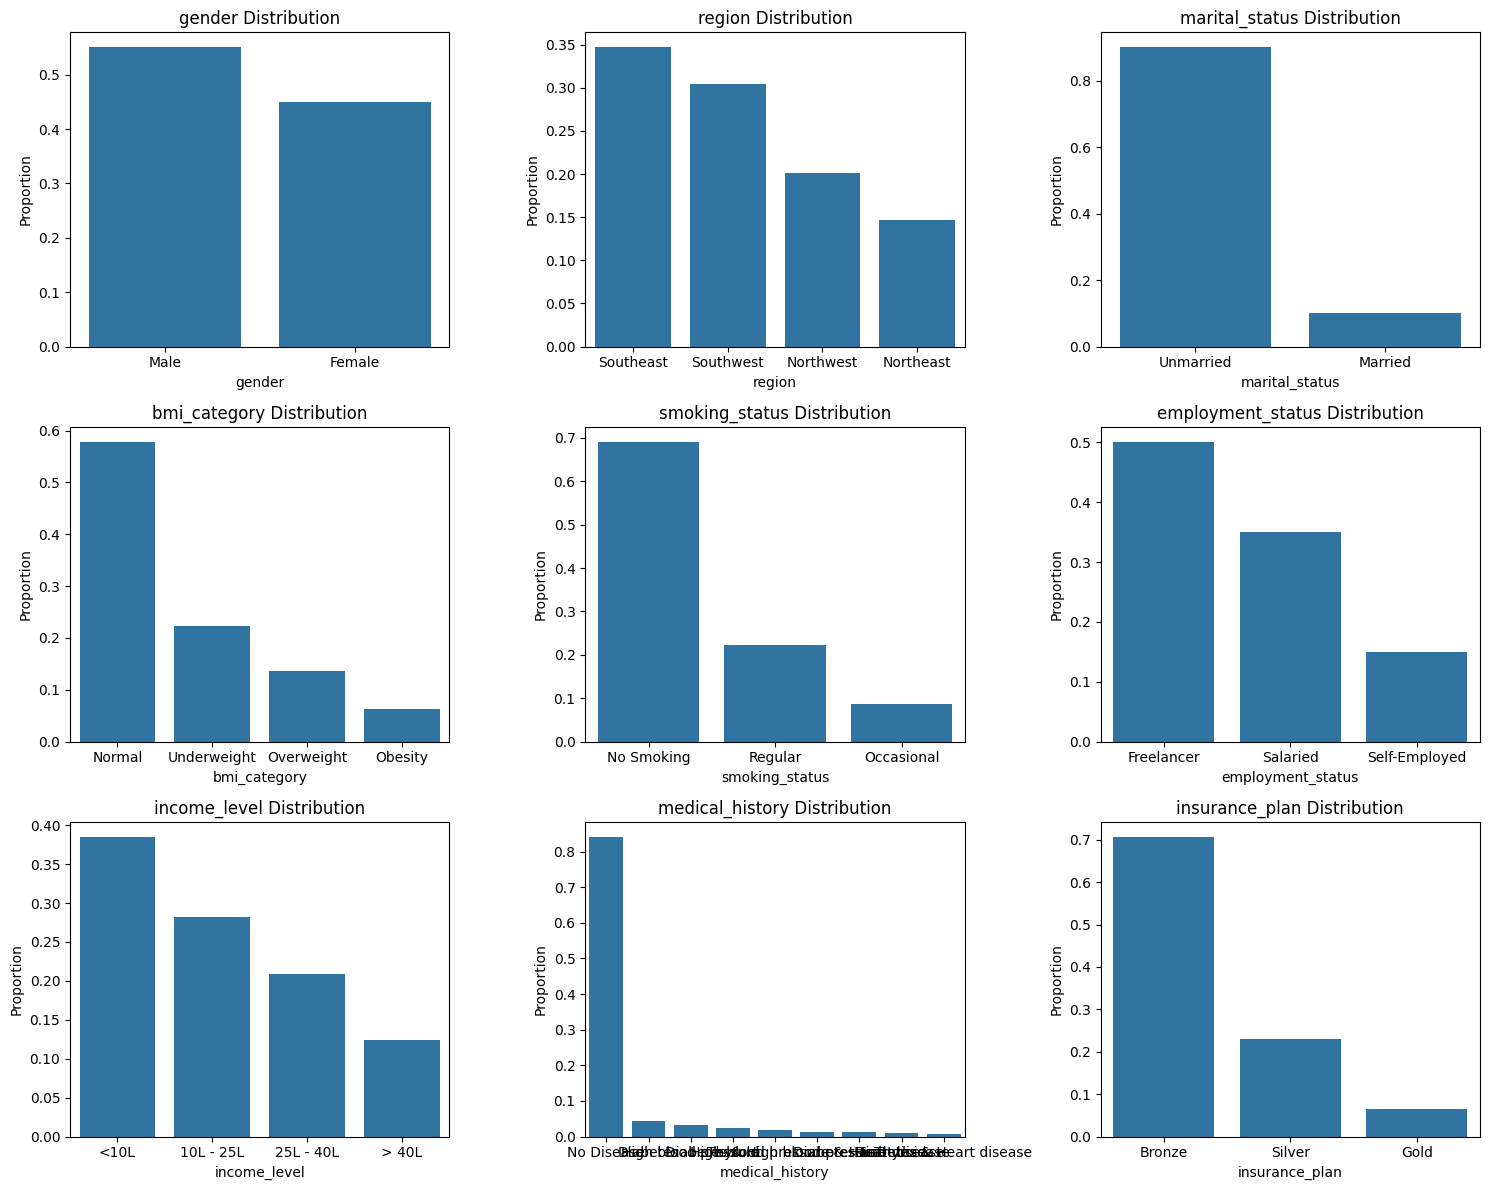

In [37]:
barPlot(df2, categorical_cols)

#### Bivariate Analysis : Categorical columns

In [38]:
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
crosstab

insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,4508,326,828
25L - 40L,3382,209,608
<10L,6172,404,1145
> 40L,115,366,2023


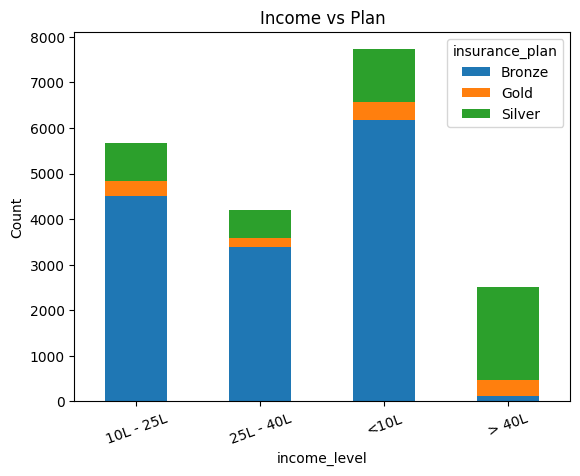

In [39]:
crosstab.plot(kind='bar', stacked=True)
plt.title('Income vs Plan')
plt.xticks(rotation=20)
plt.ylabel('Count')
plt.show()

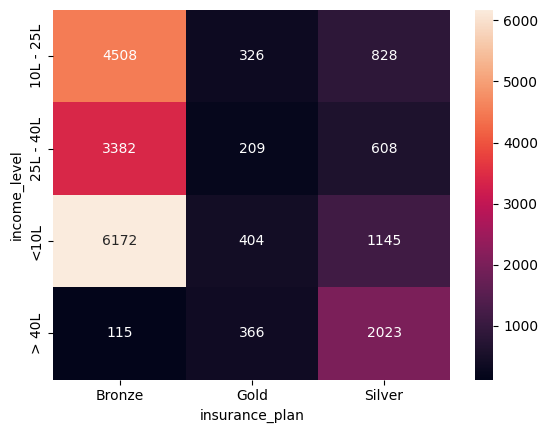

In [40]:
sns.heatmap(crosstab, annot=True, fmt='d')
plt.show()

## Feature Engineering

In [41]:
df2.medical_history.unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

In [42]:
risk_scores_dictionary = {
    'diabetes': 6,
    'heart disease': 8,
    'high blood pressure': 6,
    'thyroid': 5,
    'no disease': 0,
    'none': 0
}

In [43]:
df2[['disease1', 'disease2']] = df2.medical_history.str.split(' & ', expand=True).apply(lambda x: x.str.lower())
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,None
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,None
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,no disease,None
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,no disease,None
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,no disease,None


In [44]:
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0

df2.head()

C:\Users\Ahmad Fahim\AppData\Local\Temp\ipykernel_17696\1524846493.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['disease1'].fillna('none', inplace=True)
C:\Users\Ahmad Fahim\AppData\Local\Temp\ipykernel_17696\1524846493.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,0
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,none,0
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,no disease,none,0
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,no disease,none,0
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,no disease,none,0


In [45]:
df2['total_risk_score'] = df2['disease1'].map(risk_scores_dictionary) + df2['disease2'].map(risk_scores_dictionary)

df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,none,0
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,no disease,none,0
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,no disease,none,0
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,no disease,none,0


In [46]:
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,none,0,0.000000


In [47]:
df2.sample(5)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
1545,19,Male,Southeast,Unmarried,0,Normal,No Smoking,Salaried,> 40L,92,No Disease,Silver,11184,no disease,none,0,0.000000
10774,23,Male,Northwest,Unmarried,1,Normal,No Smoking,Salaried,> 40L,70,Thyroid,Gold,16430,thyroid,none,5,0.357143
15841,21,Male,Southwest,Unmarried,1,Normal,No Smoking,Self-Employed,25L - 40L,40,Diabetes,Silver,12563,diabetes,none,6,0.428571
15385,24,Male,Southwest,Unmarried,1,Normal,Regular,Freelancer,<10L,5,Diabetes & High blood pressure,Bronze,5026,diabetes,high blood pressure,12,0.857143
15318,24,Male,Northeast,Unmarried,1,Overweight,No Smoking,Salaried,10L - 25L,12,No Disease,Bronze,8150,no disease,none,0,0.000000


In [48]:
insurance_plan_dictionary = {
    'Bronze': 1,
    'Silver': 2,
    'Gold': 3,
}

df2['insurance_plan'] = df2['insurance_plan'].map(insurance_plan_dictionary)

In [49]:
df2['insurance_plan'].unique()

array([2, 1, 3])

In [50]:
income_level_dictionary = {
    '<10L': 1,
    '10L - 25L': 2,
    '25L - 40L': 3,
    '> 40L': 4,
}

df2['income_level'] = df2['income_level'].map(income_level_dictionary)

In [51]:
df2['income_level'].unique()

array([4, 1, 2, 3])

In [52]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,4,99,High blood pressure,2,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,1,3,No Disease,2,11050,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,4,97,No Disease,2,11857,no disease,none,0,0.000000
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,2,15,No Disease,1,5684,no disease,none,0,0.000000
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,2,14,No Disease,1,5712,no disease,none,0,0.000000


In [53]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']

df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,High blood pressure,2,13365,high blood pressure,none,6,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,no disease,none,0,...,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,No Disease,2,11857,no disease,none,0,...,1,0,1,0,0,0,0,1,1,0
3,25,0,2,15,No Disease,1,5684,no disease,none,0,...,1,0,1,0,0,0,0,0,0,0
4,20,2,2,14,No Disease,1,5712,no disease,none,0,...,1,0,1,0,1,0,0,0,0,0


In [54]:
cols_to_drop = ['disease1', 'disease2', 'total_risk_score', 'medical_history']

df4 = df3.drop(cols_to_drop, axis=1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,2,11857,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,25,0,2,15,1,5684,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,20,2,2,14,1,5712,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


### Correlation Analysis

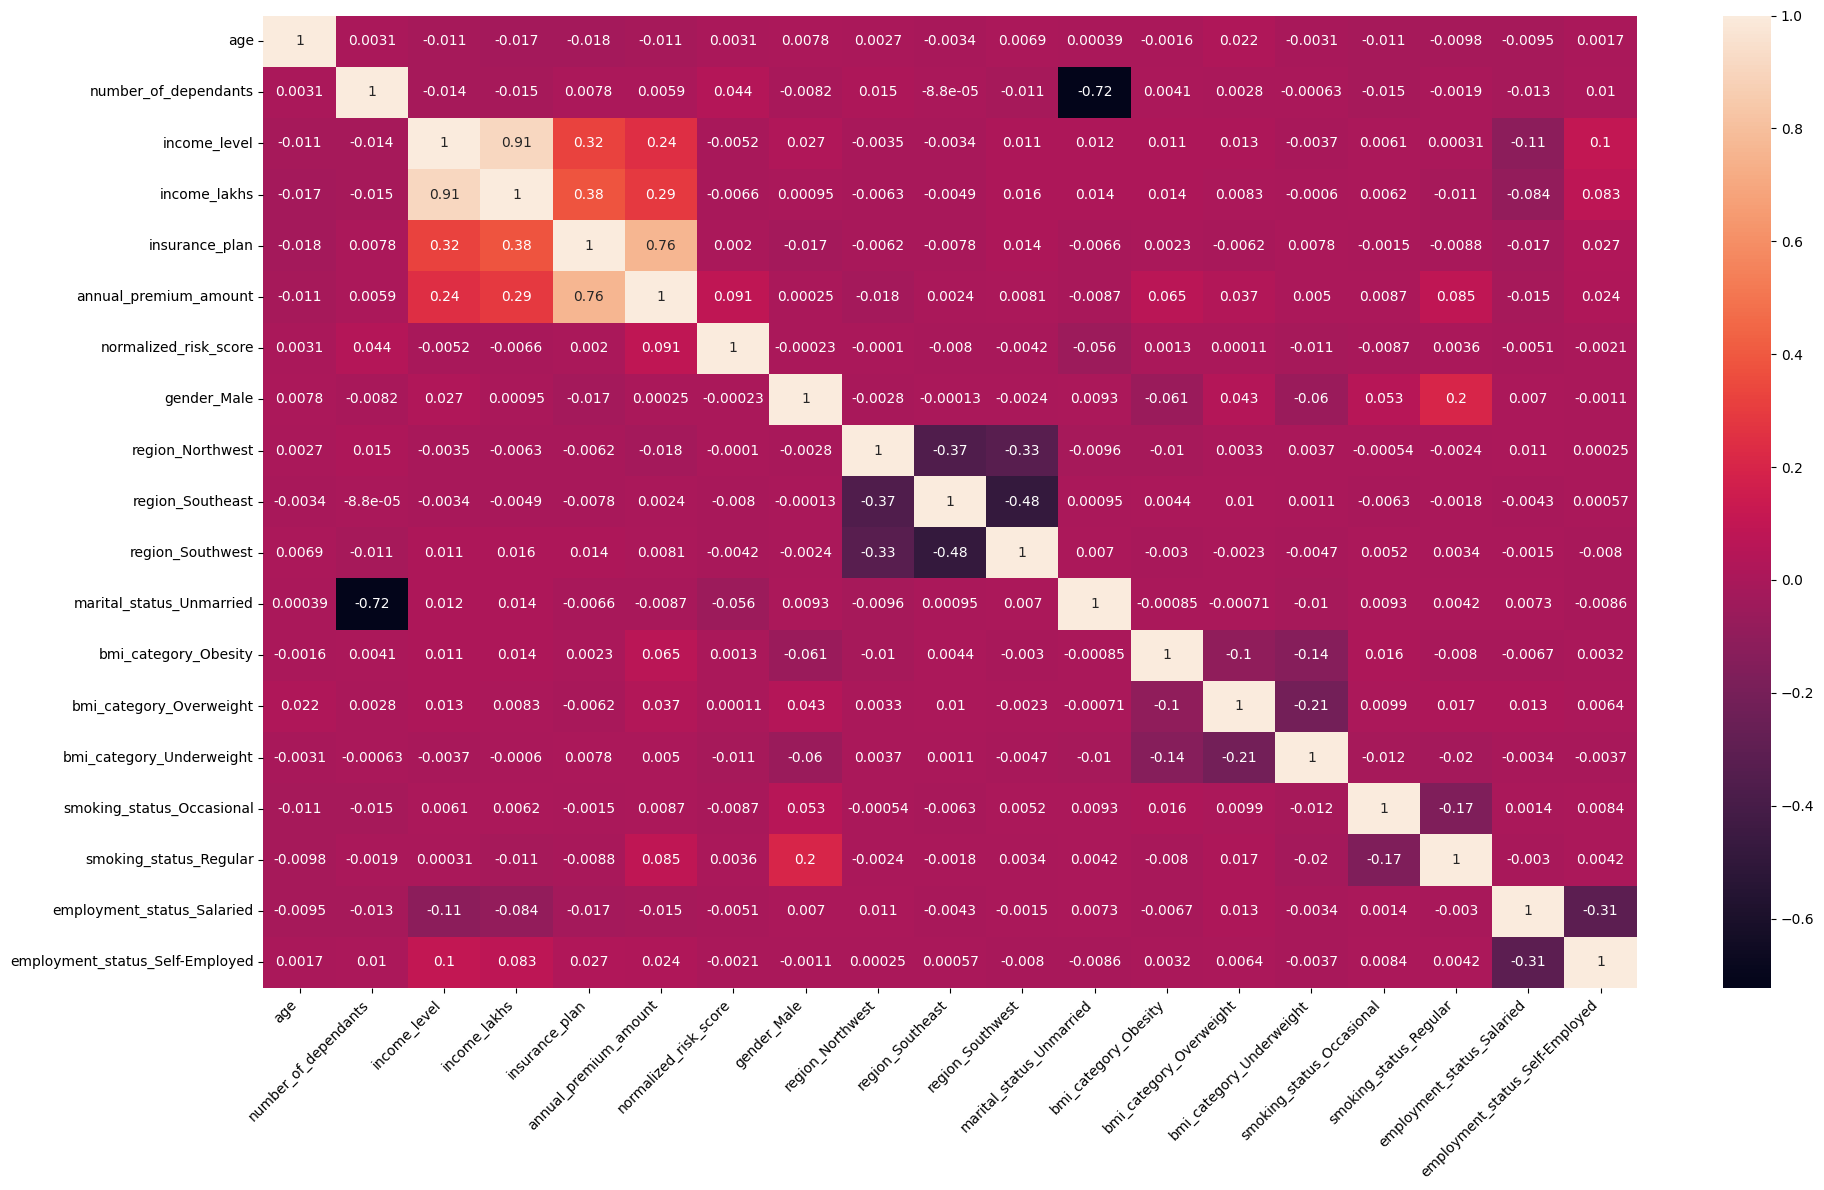

In [55]:
cm = df4.corr()

plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)
plt.tight_layout() 
plt.show()

In [56]:
X = df4.drop(target, axis='columns')
y = df4[target]

from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan']

scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])

In [57]:
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,0.499211,0.240914,0.357994,0.216064,0.179578,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.063527,0.136513,0.222493,0.086379,0.223589,0.350045,0.149955
std,0.327750,0.312413,0.347481,0.219516,0.300051,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.243914,0.343341,0.415931,0.280929,0.416660,0.476996,0.357036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.050505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.571429,0.000000,0.333333,0.151515,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.666667,0.303030,0.500000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [58]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculateVIF(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_df

In [59]:
calculateVIF(X)

,Column,VIF
0,age,3.142881
1,number_of_dependants,1.860761
2,income_level,11.928707
3,income_lakhs,11.874242
4,insurance_plan,1.592892
5,normalized_risk_score,1.154223
6,gender_Male,2.310023
7,region_Northwest,2.147701
8,region_Southeast,2.970188
9,region_Southwest,2.730503


In [60]:
X = X.drop('income_level', axis='columns')

calculateVIF(X)

,Column,VIF
0,age,3.141534
1,number_of_dependants,1.858110
2,income_lakhs,2.291873
3,insurance_plan,1.587794
4,normalized_risk_score,1.154174
5,gender_Male,2.299848
6,region_Northwest,2.146767
7,region_Southeast,2.968993
8,region_Southwest,2.729813
9,marital_status_Unmarried,7.299818


In [61]:
X.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.020202,0.5,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,0.969697,0.5,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.141414,0.0,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.131313,0.0,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


## Model Training

In [62]:
test_size = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=10)

### Linear Regression

In [63]:
model_LR = LinearRegression()
model_LR.fit(X_train, y_train)

LinearRegression()

In [64]:
train_score = model_LR.score(X_train, y_train)
test_score = model_LR.score(X_test, y_test)

print(f'Training data score: {train_score}')
print(f'Test data score: {test_score}')

Training data score: 0.6020471274164894
Test data score: 0.6047589163893645


In [65]:
y_pred = model_LR.predict(X_test)

mse = mean_squared_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {np.sqrt(mse)}')
print(f'R2 Score: {r2}')

Mean Squared Error: 3005669.8791236714
Root Mean Squared Error: 1733.6867880686152
R2 Score: 0.3530872983042673


In [66]:
X.columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'normalized_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

In [67]:
model_LR.coef_

array([ 5.51905147e+01, -1.45039643e+02, -3.60667677e+01,  7.00007042e+03,
        1.11127879e+03,  9.82564766e+00, -1.14273450e+02, -3.64663714e+01,
       -6.72232248e+01, -5.85343424e+01,  7.92952660e+02,  4.35760406e+02,
        1.69728916e+02,  2.44813937e+02,  6.19082947e+02, -1.30535485e+01,
       -4.34272200e+00])

In [68]:
model_LR.intercept_

np.float64(6614.583391230755)

In [69]:
feature_importances = model_LR.coef_

coef_df = pd.DataFrame(feature_importances, columns=['Coefficients'], index=X.columns)
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)
coef_df

,Coefficients
number_of_dependants,-145.039643
region_Northwest,-114.273450
region_Southwest,-67.223225
marital_status_Unmarried,-58.534342
region_Southeast,-36.466371
income_lakhs,-36.066768
employment_status_Salaried,-13.053549
employment_status_Self-Employed,-4.342722
gender_Male,9.825648
age,55.190515


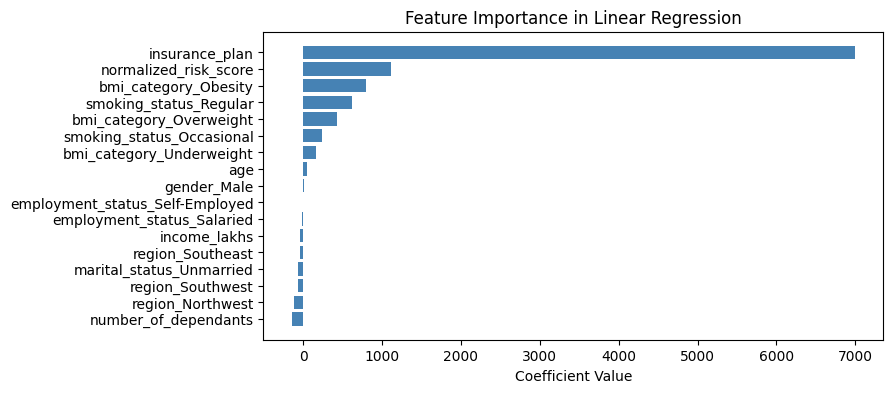

In [70]:
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df[ 'Coefficients'], color='steelblue') 
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

### Ridge Regression

In [71]:
model_RG = Ridge()
model_RG.fit(X_train, y_train)

Ridge()

In [72]:
train_score = model_RG.score(X_train, y_train)
test_score = model_RG.score(X_test, y_test)

print(f'Training data score: {train_score}')
print(f'Test data score: {test_score}')

Training data score: 0.6020466631305188
Test data score: 0.6047715291063815


In [73]:
y_pred = model_RG.predict(X_test)

mse = mean_squared_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {np.sqrt(mse)}')
print(f'R2 Score: {r2}')

Mean Squared Error: 3005573.9638324636
Root Mean Squared Error: 1733.6591256162394
R2 Score: 0.352052260906741


### XGBoost

In [74]:
from xgboost import XGBRegressor

model_XGB = XGBRegressor()
model_XGB.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [75]:
train_score = model_XGB.score(X_train, y_train)
test_score = model_XGB.score(X_test, y_test)

print(f'Training data score: {train_score}')
print(f'Test data score: {test_score}')

Training data score: 0.7251046895980835
Test data score: 0.5638787746429443


In [76]:
y_pred = model_XGB.predict(X_test)

mse = mean_squared_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {np.sqrt(mse)}')
print(f'R2 Score: {r2}')

Mean Squared Error: 3316549.0
Root Mean Squared Error: 1821.1394784584731
R2 Score: 0.32224345207214355


In [77]:
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search= RandomizedSearchCV(model_XGB, param_grid, n_iter=10, cv=3, scoring='r2', random_state=4)
random_search.fit(X_train, y_train)
random_search.best_score_

np.float64(0.5997088948885599)

In [78]:
best_model = random_search.best_estimator_

In [79]:
feature_importances = best_model.feature_importances_

coef_df = pd.DataFrame(feature_importances, columns=['Coefficients'], index=X.columns)
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)
coef_df

,Coefficients
marital_status_Unmarried,0.000000
region_Southeast,0.001213
number_of_dependants,0.001759
gender_Male,0.001809
employment_status_Salaried,0.002010
age,0.002178
employment_status_Self-Employed,0.002205
income_lakhs,0.002381
region_Northwest,0.002604
bmi_category_Underweight,0.004199


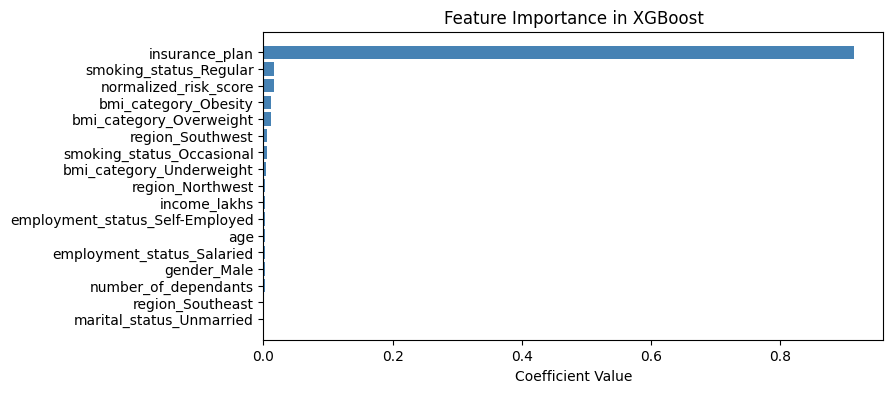

In [80]:
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df[ 'Coefficients'], color='steelblue') 
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

## Error Analysis

In [81]:
y_pred = best_model.predict(X_test)

In [82]:
residuals = y_pred - y_test
residuals_pct = residuals * 100 / y_test

In [83]:
results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'diff': residuals,
    'diff_pct': residuals_pct,
})
results_df.head()

,actual,predicted,diff,diff_pct
12774,6238,6669.329590,431.329590,6.914549
14758,9462,6999.429199,-2462.570801,-26.025902
13205,5152,6998.085449,1846.085449,35.832404
14278,6988,7868.310059,880.310059,12.597454
19351,4917,6677.658203,1760.658203,35.807570


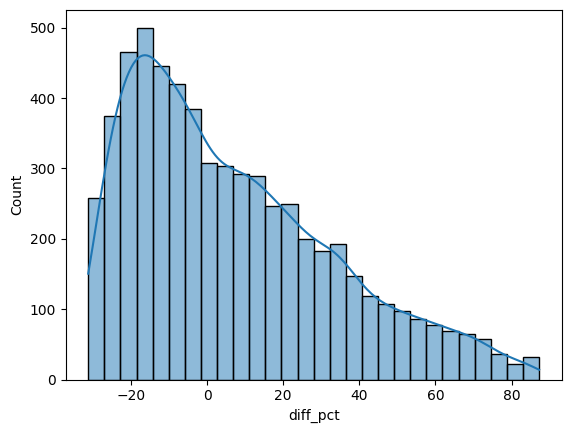

In [84]:
sns.histplot(results_df['diff_pct'], kde=True)
plt.show()

In [85]:
threshold_margin_of_error = 10
extreme_results_df = results_df[np.abs(results_df.diff_pct) > threshold_margin_of_error]

In [86]:
extreme_errors_pct = extreme_results_df.shape[0] * 100 / results_df.shape[0]
print(f'Number of rows in results : {results_df.shape[0]}')
print(f'Number of rows in extreme error : {extreme_results_df.shape[0]}')
print(f'Percentage: {extreme_errors_pct}')

Number of rows in results : 6026
Number of rows in extreme error : 4407
Percentage: 73.13308994357783


In [87]:
results_df[np.abs(results_df.diff_pct) > threshold_margin_of_error].sort_values('diff_pct', ascending=False)

,actual,predicted,diff,diff_pct
4169,3517,6584.604004,3067.604004,87.222178
4692,3516,6572.262207,3056.262207,86.924409
12285,3532,6585.947754,3053.947754,86.465112
3652,3536,6585.947754,3049.947754,86.254179
16580,3538,6585.947754,3047.947754,86.148891
...,...,...,...,...
7038,9484,6585.947754,-2898.052246,-30.557278
530,9487,6585.947754,-2901.052246,-30.579237
696,9491,6585.947754,-2905.052246,-30.608495
16059,9317,6445.819336,-2871.180664,-30.816579


In [88]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head(5)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
14758,0.285714,0.000000,0.060606,0.0,0.000000,0,0,0,1,1,0,0,0,0,1,0,1
13205,0.714286,0.333333,0.141414,0.0,0.000000,1,1,0,0,1,0,0,0,0,1,0,1
14278,0.714286,0.333333,0.222222,0.0,0.000000,1,0,1,0,1,1,0,0,0,1,0,0
19351,0.571429,0.000000,0.101010,0.0,0.000000,1,0,0,1,1,0,0,1,0,0,0,0
10622,0.428571,0.333333,0.050505,0.0,0.357143,0,0,1,0,1,0,1,0,0,0,0,0


In [89]:
import math

def compareHistPlot(data1, data2, cols):
    num_cols = len(cols)
    rows = math.ceil(num_cols / 3)  # Max 3 charts per row
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
    axes = axes.flatten()  # Flatten in case of multiple rows

    for i, col in enumerate(cols):
        sns.histplot(data1[col], kde=True, label='Overall', color='blue', ax=axes[i])
        sns.histplot(data2[col], kde=True, label='Errors', alpha=0.5, color='red', ax=axes[i])
        axes[i].legend()
        axes[i].set_title(f'Distribution of {col} for Errors vs Overall')

    # Hide unused subplots (if any)
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

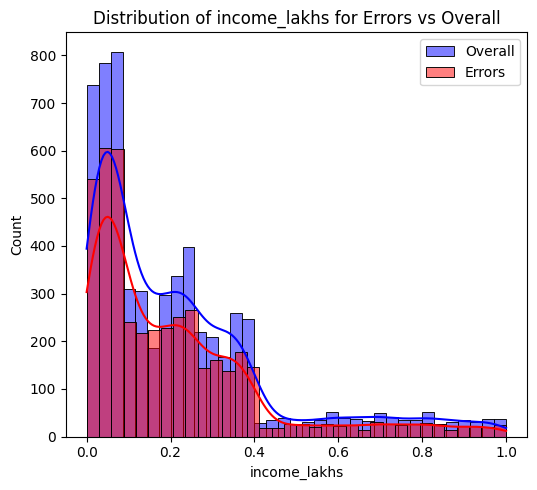

In [90]:
compareHistPlot(X_test, extreme_errors_df, ['income_lakhs'])

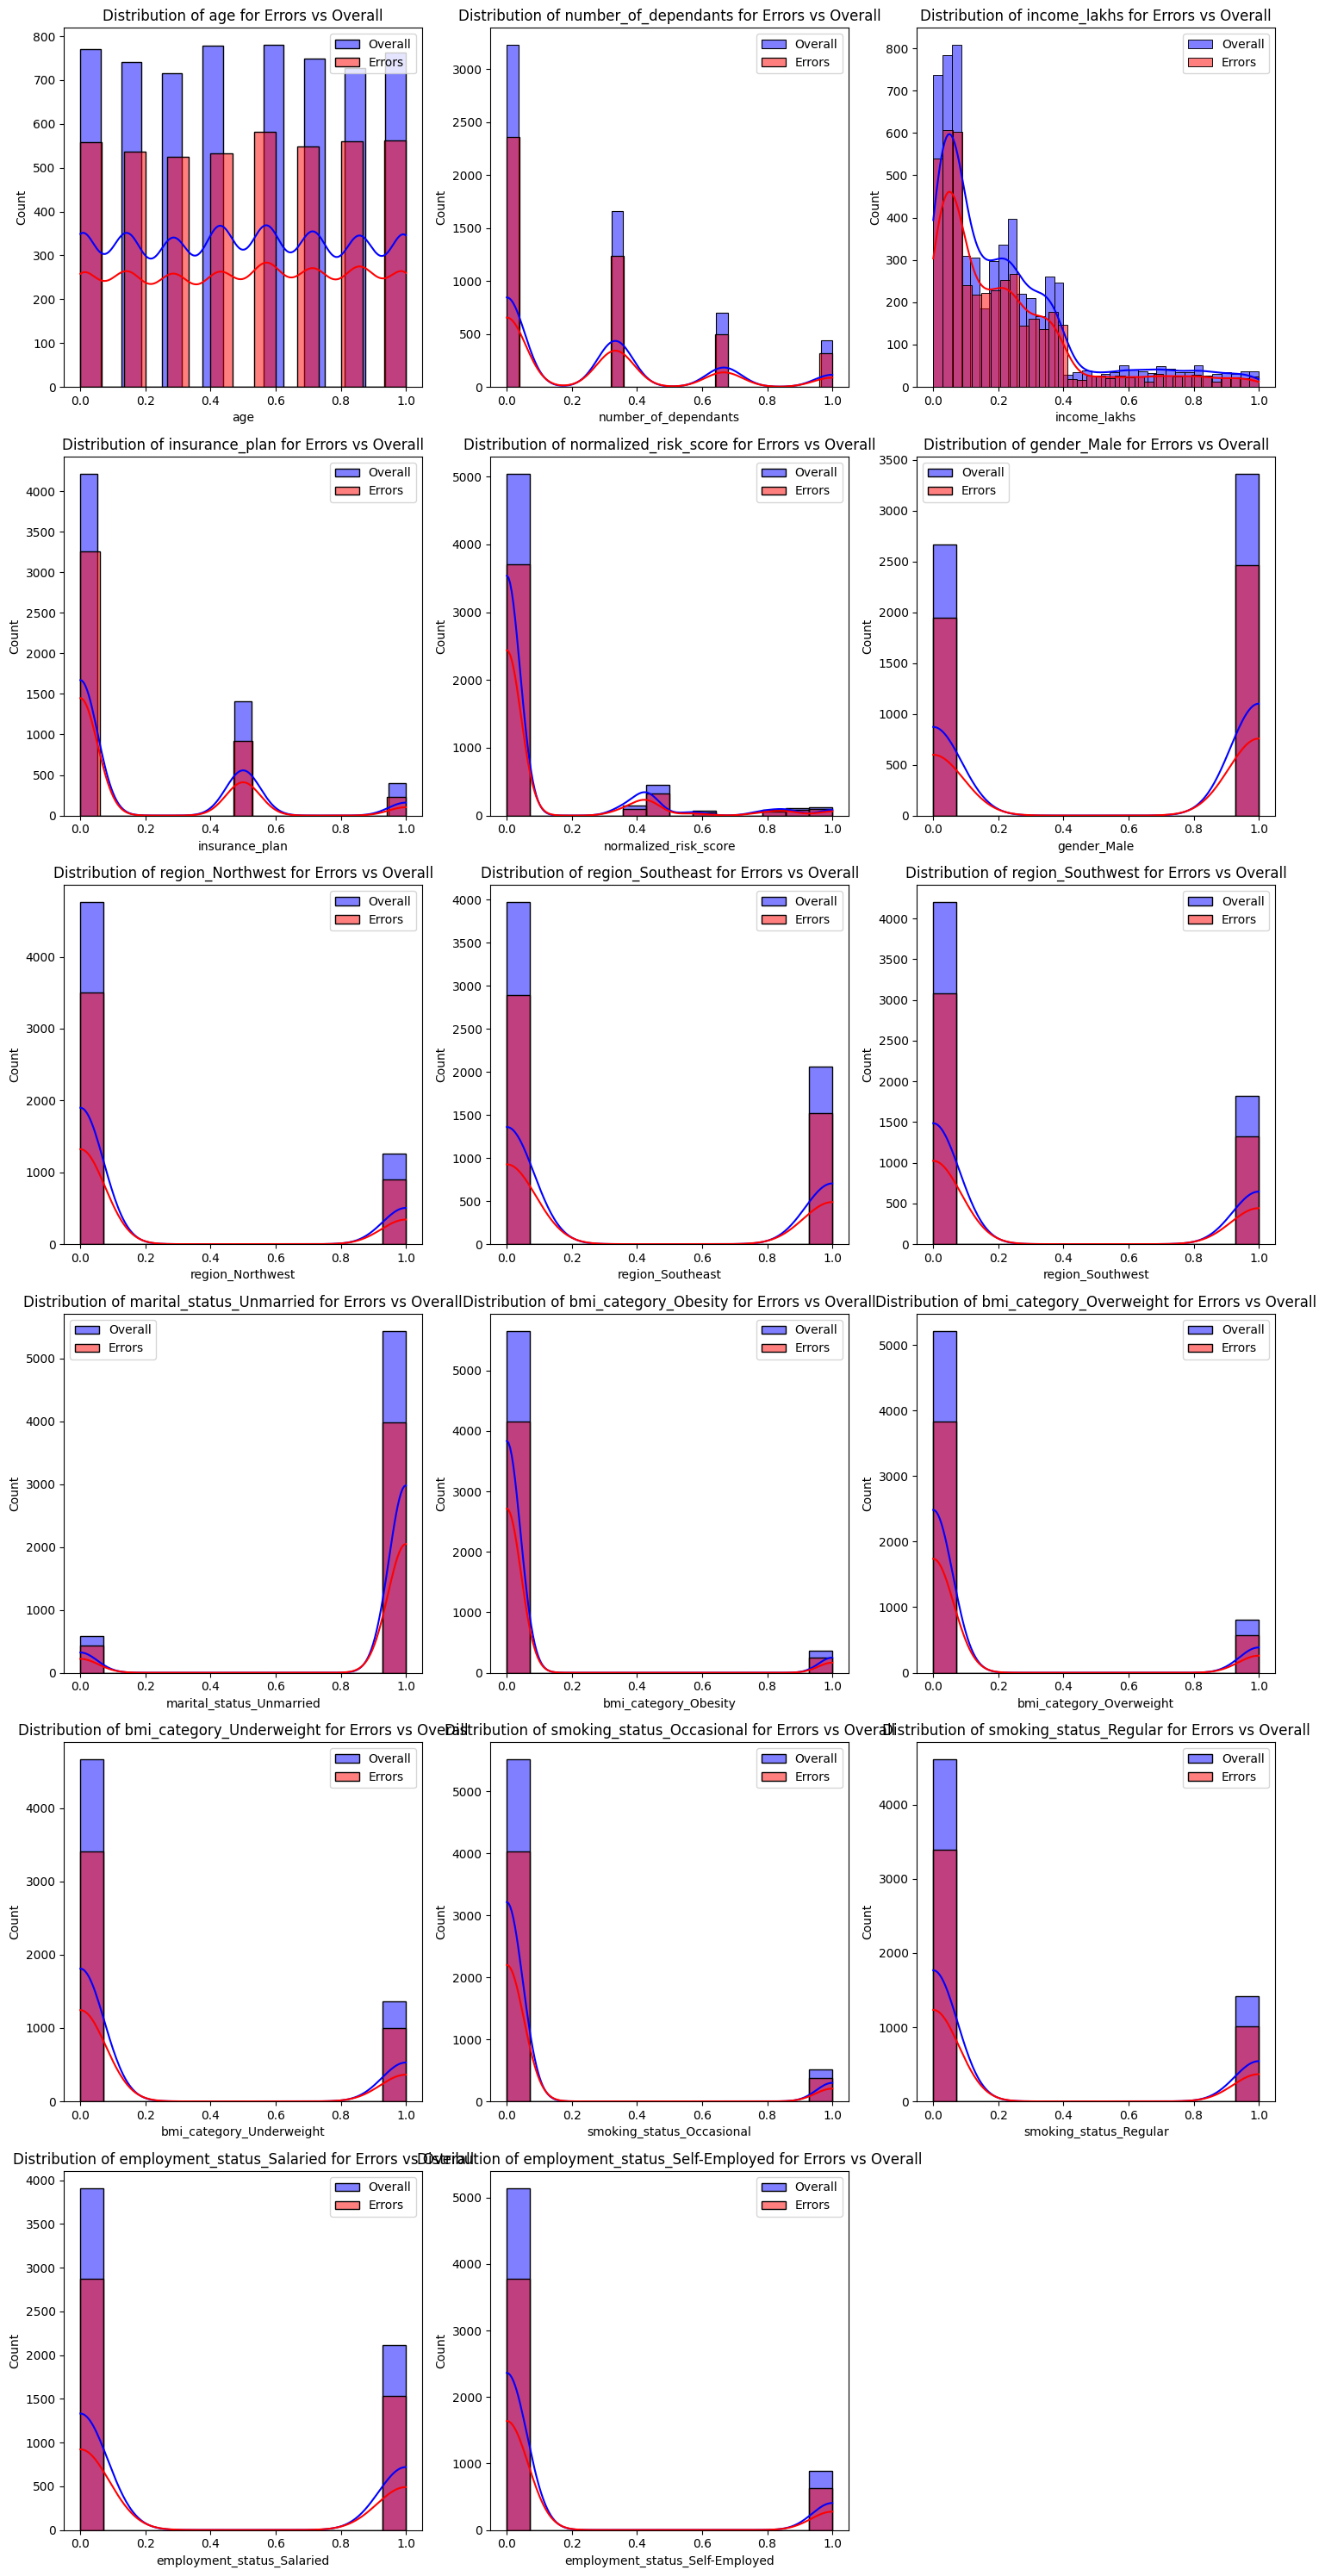

In [91]:
compareHistPlot(X_test, extreme_errors_df, X.columns)

In [92]:
extreme_errors_df['income_level'] = -1

In [93]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,20.0,0.0,-2.0,7.0,1.0
1,23.0,1.0,-2.0,15.0,1.0
2,23.0,1.0,-2.0,23.0,1.0
3,22.0,0.0,-2.0,11.0,1.0
4,21.0,1.0,-2.0,6.0,1.0
...,...,...,...,...,...
4402,19.0,2.0,-2.0,12.0,1.0
4403,22.0,0.0,-2.0,35.0,1.0
4404,24.0,1.0,-2.0,5.0,1.0
4405,18.0,0.0,-2.0,12.0,2.0


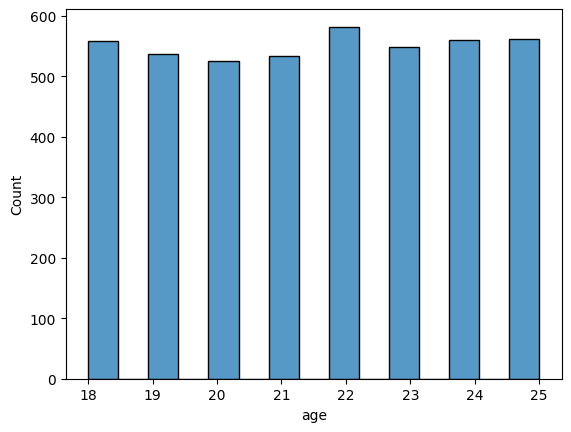

In [94]:
sns.histplot(df_reversed, x='age')
plt.show()

In [95]:
df_reversed['age'].quantile(0.98)

np.float64(25.0)